# Training a CNN in TensorFlow for cloud gap filling

Based on Tylere's tutorial https://github.com/tylere/ee-jupyter-examples/blob/master/4%20-%20Earth%20Engine%20and%20TensorFlow.ipynb - Earth Engine and TensorFlow.ipynb

In [ ]:
import ee
from IPython import display
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
# import zipfile

ee.Initialize()

### Local parameters

In [ ]:
path_clear = 'C:/Users/ipdavies/CPR/data/images/clear_4337_LC08_026038_20160325'
path_clouds = 'C:/Users/ipdavies/CPR/data/images/clouds_4337_LC08_026038_20160325'
model_name = 'cnn2'
model_path = 'C:/Users/ipdavies/CPR/data/models/'+model_name+'/'

### Load single flood scene downloaded from GEE and stack into multiband image
Each band is a separate .tif file, so this reorders them with the target feature ('flooded') last and stacks them into one multi-band .tif

In [ ]:
# Stack exported tifs from GEE into one multiband tif
import rasterio
import os

path = '../data/images/clear_4337_LC08_026038_20160325'

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

file_list = []
for file in listdir_fullpath(path):
    if file.endswith('.tif'):
        file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order

#=========== Want to rearrange the order of files so that target feature is last

# Create list of features with target feature (flooded) last
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])
    
# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# Make new directory for stacked tif if it doesn't already exist
try:
    os.mkdir(path+'/stack')
except OSError:
    pass

# Remove stack file if already exists
try:
    os.remove(path + '/stack/stack.tif')
except OSError:
    pass

with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


### Pre-process data
Load stacked image, convert -999999 NoData markers to NaN. Then, get a vector of the indices of all non-NaN values. This way, we can safely remove the NaNs, train the model, and then reshape the NaNs and predicted values into a complete image.

In [ ]:
# Preprocess the data

# Get local image
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN

# Convert -999999 to None
data[data == -999999] = np.nan

# Get indices of non-nan values. These are the indices of the original image array
# data_ind = np.where(data[:,:,1] != None)
data_ind = np.where(~np.isnan(data[:,:,1]))
row, col = zip(np.where(~np.isnan(data[:,:,1]))) # image row and col of values
len(*row)


Reshape the 3d array into a 2d array, where each row is an instance, or pixel, and each column is a feature, or band. 

In [ ]:
HOLDOUT_FRACTION = 0.1

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
data_vector.shape

# Select only the valid data and shuffle it.
# valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
# np.random.shuffle(data_vector)

# Hold out a fraction of the labeled data for validation.
training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
training_data = data_vector[0:training_size,:]
validation_data = data_vector[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands.
data_mean = training_data[:,0:14].mean(0)
data_std = training_data[:,0:14].std(0)

### Exploratory analysis of our dataset

In [ ]:
# How imbalanced is our dataset? Flooded vs. non-flooded pixels
np.sum(data_vector[:,14]==1)/np.sum(data_vector[:,14]==0)*100

### Training the CNN

In [ ]:
# Build TF model
def make_nn_layer(input, output_size):
    input_size = input.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal(
        [input_size, output_size],
        stddev=1.0 / math.sqrt(float(input_size))))
    biases = tf.Variable(tf.zeros([output_size]))
    return tf.matmul(input, weights) + biases

Instantiate neural network with two hidden layers with tanh() nonlinearities. The network has two continuous outputs, flood or non-flood. The binary output is interpreted as the argmax of these outputs. 

We define a training step, which uses Kingma and Ba's Adam algorithm to minimize the cross-entropy between the logits and the training data. Finally, we define a simple overall percentage accuracy measure.

Accuracy reported at each step, but recall/precision probably more important given the imbalanced dataset (~4% flooded in clear image, ~12% in cloud gaps)

In [ ]:
# These are all hyperparameters that might need to be tuned later
NUM_INPUT_BANDS = 14
NUM_HIDDEN_1 = 15
NUM_HIDDEN_2 = 15
NUM_CLASSES = 2

input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
labels = tf.placeholder(tf.float32, shape=[None])

normalized = (input - data_mean) / data_std
hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1))
hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2))
logits = make_nn_layer(hidden2, NUM_CLASSES)
outputs = tf.argmax(logits, 1)

int_labels = tf.to_int64(labels)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # should we minimize something else?

correct_prediction = tf.equal(outputs, int_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Want to add recall/precision to this but can do that later
# https://stackoverflow.com/questions/46409626/how-to-properly-use-tf-metrics-accuracy

import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Train the neural net

In [ ]:
# Had to alter some config and runoptions because kept running into OOM at last step during eval 
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)

config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

# import logging
# tf.logging.set_verbosity(tf.logging.INFO)

flooded = feat_list_files.index('flooded')
BATCH_SIZE = 1000
NUM_BATCHES = 1000
mySaver = tf.train.Saver()

start_time = time.time()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer(), options=run_options)
    
    training_dict = {
        input: training_data[:,0:14],
        labels: training_data[:,14],
    }

    validation_dict = {
        input: validation_data[:,0:14],
        labels: validation_data[:,14],
    }

    for i in range(NUM_BATCHES):
        batch = training_data[np.random.choice(training_size, BATCH_SIZE, False),:]
        train_step.run({input: batch[:,0:14], labels: batch[:,14]})

        if i % 100 == 0 or i == NUM_BATCHES - 1:
#             print('Accuracy %.2f%% at step %d' % (accuracy.eval(validation_dict) * 100, i))
#             print('Train acc. %.2f%%, val acc. %.2f%%, train recall %.2f%, val recall %.2f%, train precision %.2f%, val precision %.2f%, at step %d' 
            print('Train acc. %.2f%%, val acc. %.2f%%, at step %d' 
                  % (accuracy.eval(training_dict) * 100,
                     accuracy.eval(validation_dict) * 100, 
                     i))

    output_data = outputs.eval({input: data_vector[:,0:14]})
    
    # Save the model
    mySaver.save(sess, model_path+model_name+'.ckpt', global_step = NUM_BATCHES)

print('CNN training runtime: ' + timer(start_time, time.time()))

### Performance metrics

In [10]:
from sklearn import metrics

# Confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(metrics.confusion_matrix(data_vector[:,14], output_data)/len(output_data)*100, labels=['notFlooded','Flooded'])


               notFlooded    Flooded 
    notFlooded       95.8        0.2 
       Flooded        0.7        3.3 
CNN Recall:  0.8185302773566396


In [11]:
print('CNN Recall: ', metrics.recall_score(data_vector[:,14], output_data))
print('Cnn Precision: ', metrics.precision_score(data_vector[:,14], output_data))

CNN Recall:  0.8185302773566396
Cnn Precision:  0.9416917697466162


Visualizing actual vs. predicted flooding on clear image (training)

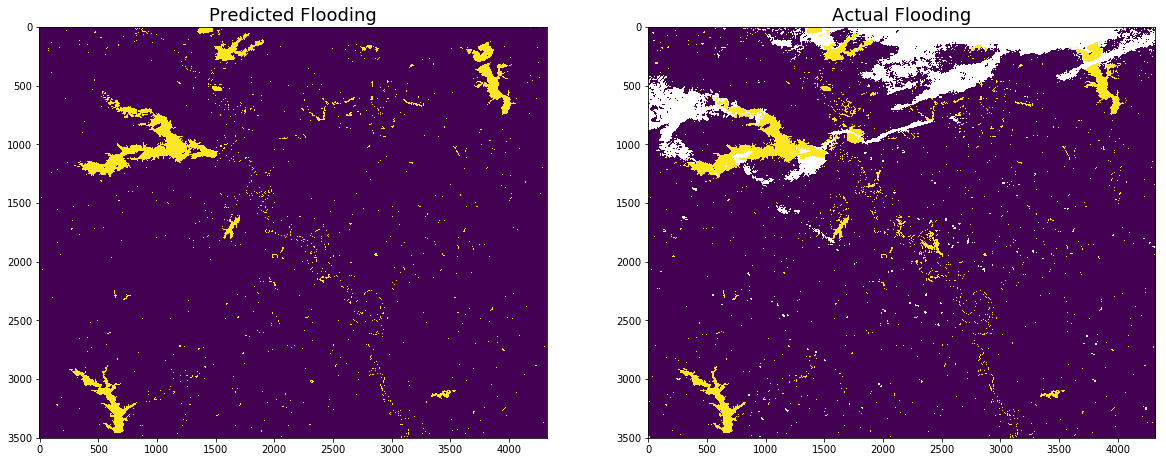

In [12]:
# Reshape predicted values back into image band
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(2).shape # Shape of full original image
        arr_empty = np.zeros(shape) # Create empty array with this shape

output_image = arr_empty
rows, cols = zip(data_ind)
output_image[rows, cols] = output_data

plt.figure(figsize=(20,30))
columns = 2
images = [output_image, data[:,:,14]]
titles = ['Predicted Flooding','Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

#### Should I add weights to cross entropy to account for imbalanced dataset?

https://stats.stackexchange.com/questions/197273/class-balancing-in-deep-neural-network

https://stackoverflow.com/questions/35155655/loss-function-for-class-imbalanced-binary-classifier-in-tensor-flow

https://datascience.stackexchange.com/questions/30930/accuracy-and-loss-dont-change-in-cnn-is-it-over-fitting


## Fill cloud gaps using trained CNN
### Load and pre-process cloud gap image

In [20]:
# Stack exported tifs from GEE into one multiband tif
import rasterio
import os

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

file_list = []
for file in listdir_fullpath(path_clouds):
    if file.endswith('.tif'):
        file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order

#=========== Want to rearrange the order of files so that target feature is last

# Create list of features with target feature (flooded) last
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])
    
# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# Make new directory for stacked tif if it doesn't already exist
try:
    os.mkdir(path_clouds+'/stack')
except OSError:
    pass

# Remove stack file if already exists
try:
    os.remove(path_clouds + '/stack/stack.tif')
except OSError:
    pass

with rasterio.open(path_clouds + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


#=======================================================================================

# Preprocess the data

# Get local image
with rasterio.open(path_clouds + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN

# Convert -999999 to None
data[data == -999999] = np.nan

# Get indices of non-nan values. These are the indices of the original image array
# data_ind = np.where(data[:,:,1] != None)
data_ind = np.where(~np.isnan(data[:,:,1]))
row, col = zip(np.where(~np.isnan(data[:,:,1]))) # image row and col of values
len(*row)


#=======================================================================================

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
data_vector.shape

# Hold out a fraction of the labeled data for validation.
# training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
# training_data = data_vector[0:training_size,:]
# validation_data = data_vector[training_size:-1,:]

# Compute per-band means and standard deviations of the input bands.
data_mean = training_data[:,0:14].mean(0)
data_std = training_data[:,0:14].std(0)

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


### Import trained CNN and predict on cloud gaps

In [21]:
# Need to read up on checkpoints and saved models
# https://www.tensorflow.org/guide/checkpoints

# Had to alter some config and runoptions because kept running into OOM at last step during eval 
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)

config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

# Prepare feed dictionary

new_input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS])
new_labels = tf.placeholder(tf.float32, shape=[None])

normalized = (input - data_mean) / data_std

with tf.Session(config=config) as sess:
    mySaver = tf.train.import_meta_graph(model_path+model_name+'.ckpt-1000.meta')
#     saver.restore(sess, tf.train.latest_checkpoint(model_path+'./'))
#     mySaver.restore(sess, model_path+'cnn2.ckpt-1000')
    mySaver.restore(sess, tf.train.latest_checkpoint(model_path+'./'))
    
    pred_data = outputs.eval({input: data_vector[:,0:14]})
    # graph = tf.get_default_graph()
    # print([n.name for n in graph.as_graph_def().node])

INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn2/cnn2.ckpt-1000


### Performance metrics on cloud gaps

In [29]:
# How imbalanced is our dataset? Flooded vs. non-flooded pixels
print('Cloud gaps contain ' + str(round(np.sum(data_vector[:,14]==1)/np.sum(data_vector[:,14]==0)*100, 2)) + '% flooded pixels')

Cloud gaps contain 12.88% flooded pixels


               notFlooded    Flooded 
    notFlooded       88.2        0.4 
       Flooded        1.1       10.3 
CNN Recall:  0.904770288329959
Cnn Precision:  0.9597545033191287


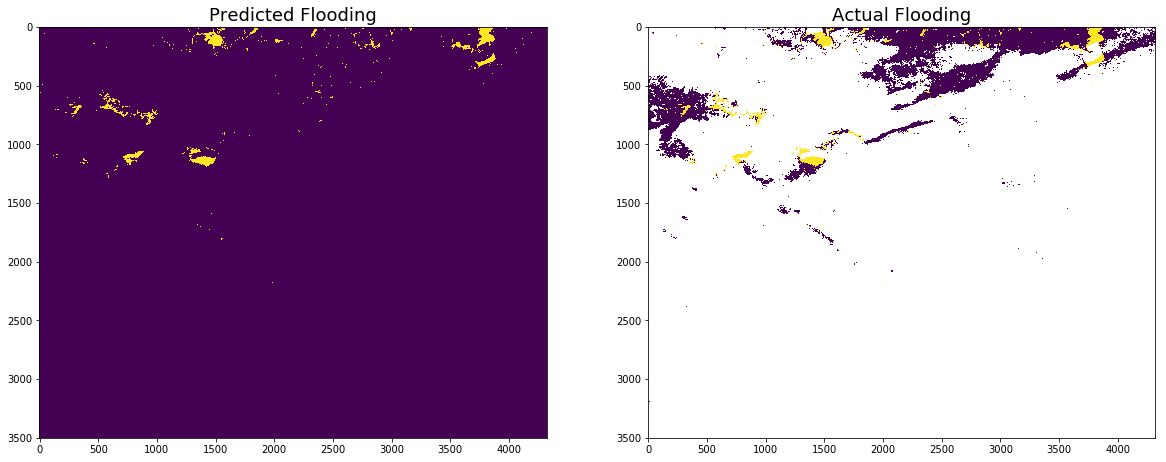

In [23]:
# Confusion matrix
print_cm(metrics.confusion_matrix(data_vector[:,14], pred_data)/len(pred_data)*100, labels=['notFlooded','Flooded'])

print('CNN Recall: ', metrics.recall_score(data_vector[:,14], pred_data))
print('CNN Precision: ', metrics.precision_score(data_vector[:,14], pred_data))

# Reshape predicted values back into image band
with rasterio.open(path_clouds + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(2).shape # Shape of full original image
        arr_empty = np.zeros(shape) # Create empty array with this shape

output_image = arr_empty
rows, cols = zip(data_ind)
output_image[rows, cols] = pred_data


plt.figure(figsize=(20,30))
columns = 2
images = [output_image, data[:,:,14]]
titles = ['Predicted Flooding','Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar
plt.show()